# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

### Импортируем библиотеки 

In [79]:
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

### Ознакомимся с данными.

* Запишим данные в переменную data.

In [80]:
data = pd.read_csv('/datasets/users_behavior.csv')

* Выведим первые 10 строк.

In [81]:
data.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Итак количество данных у нас не большое всего 3214 строк и 5 столбцов.

Признаком классификации послужит столбец `is_ultra`.  1 - тариф "Ультра", 0 - тариф "Смарт" \
Взглянем на соотношение тарифов "Смарт" к "Ультра".

In [83]:
data['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

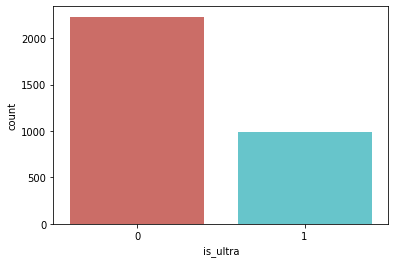

In [84]:
sns.countplot(x='is_ultra', data=data, palette='hls');

Мы видим что тарифов "Ультра" примерно в 2 раза меньше чем "Смарт".

## Разбейте данные на выборки

### Сохраним признаки в отдельные переменные. 

* `features`- признаки, `target`- целевой признак.

In [85]:
features = data.drop(['is_ultra'], axis=1)
target = data['is_ultra']

### Разобьём исходные данные на обучающую, валидационную и тестовую выборку.

* Воспользуемся **train_test_split**, и  разабьем на 60%, 20% и 20%

In [86]:
# Сначала разобьем на обучающие и валидационные выборки 60% и 40%.

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)

# Теперь разобьем на валидационную и тестовую выборку 50% на 50%.

features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

In [87]:
print('Количество строк на обучающей выборке', features_train.shape[0])
print('Количество строк на валидационной выборке', features_valid.shape[0])
print('Количество строк на тестовую выборку', features_test.shape[0])

Количество строк на обучающей выборке 1928
Количество строк на валидационной выборке 643
Количество строк на тестовую выборку 643


## Исследуйте модели

###  Воспользуемся моделью "Случайного леса".

In [89]:
parametrs_forest = {'max_depth': list(range (1,11)),
                    'min_samples_split': list(range (2,10,2))}

model_forest = GridSearchCV(RandomForestClassifier(random_state=12345), parametrs_forest, cv=5)
model_forest.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 4, 6, 8]})

In [90]:
result_forest = model_forest.score(features_valid, target_valid)
print("Accuracy наилучшей модели на валидационной выборке:", format(result_forest, '.2%'))

Accuracy наилучшей модели на валидационной выборке: 80.56%


Доля правильных ответов составила 80.56% не плохой результат. Т.к данных не много, модель обучается не долго.  Посмотрим еще на другие модели. 

### Обучим модель логистической регрессии

In [91]:
# Определяем тестируемые значения гиперпараметров.

parametr_set_logic = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

# Повысим качество модели на кросс-валидации

best_model_logic = GridSearchCV(LogisticRegression(random_state=12345,), parametr_set_logic, cv=3)

# Обучаем модель

best_model_logic.fit(features_train, target_train) 

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=12345),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]})

In [92]:
print("Лучшие параметры:", best_model_logic.best_params_)
print("Лучший результат кросс-валидации", format(best_model_logic.best_score_, '.2%'))

Лучшие параметры: {'C': 0.05}
Лучший результат кросс-валидации 75.00%


Доля правильных ответов оказалась хуже чем у случайного леса, и составило всего 75.00%.

### Обучим модель "Дерево решений"

In [93]:
# Определяем тестируемые значения гиперпараметров.

parametr_set = {
    'criterion': ['entropy', 'gini'],
    'max_depth': list(range(1, 5)),
    'min_samples_split': list(range(8, 12)),
    'min_samples_leaf': list(range(1, 5))
}

# Повысим качество модели на кросс-валидации.

best_model_tree = GridSearchCV(DecisionTreeClassifier(random_state=17),
                                parametr_set, verbose=True,
                                 n_jobs=-1, cv=5)

# Обучаем модель.

best_model_tree.fit(features_train, target_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [1, 2, 3, 4],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [8, 9, 10, 11]},
             verbose=True)

In [94]:
print("Лучшие параметры:", best_model_tree.best_params_)
print("Лучший результат кросс-валидации", format(best_model_tree.best_score_, '.2%'))

Лучшие параметры: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10}
Лучший результат кросс-валидации 80.19%


Лучшей моделью оказалась модель "Случайного леса" с результатом Accuracy 80.56%. Так же не плохой результат получилось добиться у "Дерево решений" с точностью 80.19%. И хуже всех показала модель "Логистической регрессии" с 75.00%.

## Проверьте модель на тестовой выборке

* Делаем предсказание по всем моделям и проверм на правильность моделей на тестовой выборке. 

In [95]:
# Предсказание для "Случайного леса"

predictions_test_forest = model_forest.predict(features_test)

# Проверяем правильность модели. 

result_forest = accuracy_score(target_test, predictions_test_forest)
print("Качество:", format(result_forest, '.2%'))

Качество: 79.47%


In [96]:
# Предсказание для "Логистической регрессии"

predictions_test_logic = best_model_logic.predict(features_test)

# Проверяем правильность модели.

result_logic = accuracy_score(target_test, predictions_test_logic)
print("Качество:", format(result_logic, '.2%'))

Качество: 75.58%


In [97]:
# Предсказание для "Дерево решений"

predictions_test_tree = best_model_tree.predict(features_test)

# Проверяем правильность модели.

result_tree = accuracy_score(target_test, predictions_test_tree)
print("Качество:", format(result_tree, '.2%'))

Качество: 77.92%


**Вывод:** И так мы разбили данные на 3 выборки, **обучающую, валидационную и тестовую**. Обучили три модели **"Случайного леса", "Логистической регрессии", и "Дерево решений"**. Для улучшения моделей использовали гиперпараметры. По данным моделям мы будем оценивать долю правильных ответов **Accuracy**, которая поможет для наших клиентов подобрать оптимальный тарифный план.

На валидационной выборке наиболее эффективной себя показала модель **"Случайного леса"** правильность модели составило 80.56%.  На тестовой выборке отличный результат опять же показывает модель **"Случайного леса"** - 79.47%. Данная модель и послужит помощником для предложения клиентам новых тарифов. Другие две модели на тестовой выборке показали хуже результат **"Логистической регрессии"** - 75.58% и **"Дерево решений"** - 77.92%. 

* Рассмотрим **RMSE** метрику, для определения адекватности модели.

**RMSE:** метрика, которая сообщает нам квадратный корень из средней квадратичной разницы между прогнозируемыми значениями и фактическими значениями в наборе данных. Чем ниже RMSE, тем лучше модель соответствует набору данных.

**Воспользуемся DummyClassifier который нам даст представление о минимальном качестве которое мы можем достичь.**

In [101]:
baseline_model = DummyClassifier(strategy="most_frequent").fit(features_train, target_train)

print("Результат простой модели на валидационной выборке:", baseline_model.score(features_train, target_train))
print("Результат простой модели на тестовой выборке:", baseline_model.score(features_test, target_test))

Результат простой модели на валидационной выборке: 0.6924273858921162
Результат простой модели на тестовой выборке: 0.7060653188180405


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [ ] Весь код исполняется без ошибок
- [ ] Ячейки с кодом расположены в порядке исполнения
- [ ] Выполнено задание 1: данные загружены и изучены
- [ ] Выполнено задание 2: данные разбиты на три выборки
- [ ] Выполнено задание 3: проведено исследование моделей
    - [ ] Рассмотрено больше одной модели
    - [ ] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [ ] Написаны выводы по результатам исследования
- [ ] Выполнено задание 3: Проведено тестирование
- [ ] Удалось достичь accuracy не меньше 0.75
